# Backpropagation DEMO

This demo demonstrate how a neural network is trained through backpropagation to learn the relationship between input data $x$ and corresponding labels $y$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## 1. Generate our data

Fist, generate two $x$ values representing the horizontal and vertical coordinates of points on a 2D plane. These points will form the imput data for our neural network.

In [129]:
sample_size = 1000
np.random.seed(71)
x_mat = np.random.uniform(-1, 1, size = (sample_size, 2)) 
x_mat_bias = np.ones((sample_size, 1))
x_mat_extended = np.concatenate((x_mat, x_mat_bias), axis = 1)

Now let's generate our $y$ values. **Pick one pattern below and comment out the rest**. The purpose of these patterns is to generate data distributions in different geometric shapes, allowing us to train and test the neural network’s ability to learn from these varied distribution patterns. Each pattern represents a specific classification rule, and the neural network needs to learn these patterns through training in order to correctly classify data points based on different feature distributions.

In [130]:
# Circle pattern 0.986
#y = (np.sqrt(x_mat_extended[:,0]**2 + x_mat_extended[:,1]**2) < .75).astype(int)
# Region: Generates a circular region with a radius of 0.75 centered at the origin. Points inside the circle are labeled as 1, and points outside are labeled as 0.
# This pattern requires the neural network to recognize a smooth, rounded boundary, which can be challenging for models that may initially prefer linear boundaries.


# Centered square 0.957
#y = ((np.maximum(np.abs(x_mat_extended[:,0]), np.abs(x_mat_extended[:,1])) < .5).astype(int))
# Region: Creates a centered square region with each side length of 1. Points inside the square are labeled as 1, and points outside are labeled as 0.
# The square boundaries are axis-aligned, making it relatively simple for the neural network to approximate using linear decision boundaries.


# Ellipse Pattern 0.977
#y = ((x_mat_extended[:, 0]**2 / 0.6**2 + x_mat_extended[:, 1]**2 / 0.3**2) < 1).astype(int)
# Region: Generates an elliptical region with the major and minor axes aligned to the x and y axes. Points inside the ellipse are labeled as 1.
# The elliptical shape may require the neural network to adjust to a non-uniform boundary, which is more complex than a simple circle or square.


# Cross Pattern 0.951
#y = (((np.abs(x_mat_extended[:, 0]) < 0.2) | (np.abs(x_mat_extended[:, 1]) < 0.2))).astype(int)
# Region: Creates a cross-shaped region with two narrow strips along the x-axis and y-axis. Points in either strip are labeled as 1.
# The neural network must recognize two separate linear regions, which may require a more complex structure to correctly separate these narrow and intersecting boundaries.


# Ring Pattern 0.734
#y = ((np.sqrt(x_mat_extended[:,0]**2 + x_mat_extended[:,1]**2) < 0.75) & (np.sqrt(x_mat_extended[:,0]**2 + x_mat_extended[:,1]**2) > 0.5)).astype(int)
# Region: Generates a ring with points between radius 0.5 and 0.75 labeled as 1.
# The neural network must learn two circular boundaries (inner and outer), which is more complex than a single, smooth boundary like a circle or square.


# Diamond pattern 0.986
y = ((np.abs(x_mat_extended[:,0]) + np.abs(x_mat_extended[:,1])) < 1).astype(int)
# Region: Forms a diamond shape with boundaries aligned along the diagonals. Points within the diamond are labeled as 1.
# Although the boundaries are linear, their diagonal alignment may require the network to recognize non-axis-aligned boundaries, which could be more difficult.


# Thick right angle pattern 0.978
#y = (((np.maximum((x_mat_extended[:,0]), (x_mat_extended[:,1])) < .5) & ((np.maximum((x_mat_extended[:,0]), (x_mat_extended[:,1])) > -.5))).astype(int))
# Region: Forms a thick “L” or right-angle shape that spans both positive and negative regions of the axes. Points within this shape are labeled as 1.
# The neural network needs to learn two distinct boundaries (horizontal and vertical) and combine them, which can be complex.


# Thin right angle pattern 0.985
#y = (((np.maximum((x_mat_extended[:,0]), (x_mat_extended[:,1])) < .5) & ((np.maximum((x_mat_extended[:,0]), (x_mat_extended[:,1])) > 0))).astype(int))
# Region: Generates a narrow “L” shape that only occupies the positive region of the x and y axes.
# The thin boundaries make it difficult for the neural network to accurately separate the regions, as it must be precise in capturing these narrow strips.

After choosing a pattern, let’s generate a plot to see what it looks like!

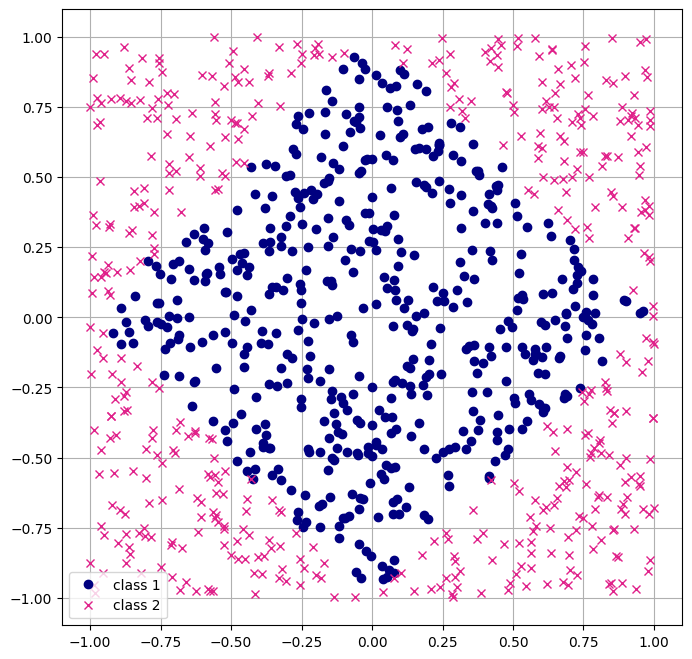

In [131]:
fig, ax = plt.subplots(figsize = (8,8))
ax.plot(x_mat_extended[y==1, 0], x_mat_extended[y==1, 1], 'o', label = 'class 1', color = '#000080')
ax.plot(x_mat_extended[y==0, 0], x_mat_extended[y==0, 1], 'x', label = 'class 2', color = '#E0218A')
ax.grid(True)
ax.legend(loc = 'best')

## 2. Define the core functions for training our neural network

First，pick one activation functions from below and **comment out the rest**：

In [116]:
#sigmoid
def activation_f(x):
    return 1.0 / (1.0 + np.exp(-x))

#relu
# def activation_f(x):
#     return np.maximum(0, x)

#tanh
# def activation_f(x):
#     return np.tanh(x)

Now, we need to define other core functions needed for training our neural network:

1. **Loss Function**: The `loss_fn` function calculates the logarithmic loss between the predicted values (`y_pred`) and the actual values (`y_true`). Log loss is commonly used for binary classification tasks as it effectively measures the difference between predicted probabilities and true labels. It penalizes highly confident but incorrect predictions more heavily, guiding the model to output probabilities that align with actual labels. Our goal is to minimize this value during training.

2. **Forward Pass and Gradient Calculation**: The `forward_pass` function performs a single forward pass through the network, generating predictions (`y_pred`). It also calculates the gradients of the loss with respect to the weights (`W1` and `W2`) for use in backpropagation, allowing us to adjust the weights to minimize the loss.

3. **Plotting Loss and Accuracy**: The `plot_loss_accuracy` function plots the log loss and accuracy over the training iterations, enabling us to visualize the network’s performance improvements as it learns.

In [121]:
def loss_fn(y_true, y_pred, eps=1e-16):
    # Clip y_pred values to the range [eps, 1 - eps] to avoid log(0) or log(1) errors during logarithmic loss calculation
    y_pred = np.maximum(y_pred, eps)
    y_pred = np.minimum(y_pred, 1 - eps)
    return -(np.sum(y_true * np.log(y_pred)) + np.sum((1 - y_true) * np.log(1 - y_pred))) / len(y_true)

def forward_pass(W1, W2):
    layer1 = np.dot(x_mat, W1)
    layer1_activation = activation_f(layer1)
    layer2 = np.dot(layer1_activation, W2)
    y_pred = activation_f(layer2).reshape((len(x_mat),))
    J_layer2_grad = -y + y_pred
    J_W2_grad = np.dot(J_layer2_grad, layer1_activation)
    layer1_activation_layer1_grad = activation_f(layer1)*(1-activation_f(layer1))
    J_W1_grad = (np.dot((J_layer2_grad).reshape(-1,1), W2.reshape(-1,1).T)*layer1_activation_layer1_grad).T.dot(x_mat).T
    gradient = (J_W1_grad, J_W2_grad)
    return y_pred, gradient

def plot_loss_accuracy (loss_vals, accuracies):
    fig = plt.figure(figsize = (16, 8))
    fig.suptitle('Log loss and Acurracy over Iterations')
    ax = fig.add_subplot(1, 2, 1)
    ax.plot(loss_vals, color = '#000080')
    ax.grid(True)
    ax.set(xlabel='iterations', title='Log Loss')
    ax = fig.add_subplot(1, 2, 2)
    ax.plot(accuracies, color = '#000080')
    ax.grid(True)
    ax.set(xlabel='iterations', title='Accurary')


## 3. Let's see the results!

iteration 0, log loss is 0.7053, accuracy is 0.489
iteration 500, log loss is 0.4444, accuracy is 0.907
iteration 1000, log loss is 0.2064, accuracy is 0.96
iteration 1500, log loss is 0.1668, accuracy is 0.971
iteration 2000, log loss is 0.1497, accuracy is 0.976
iteration 2500, log loss is 0.1392, accuracy is 0.976
iteration 3000, log loss is 0.1316, accuracy is 0.978
iteration 3500, log loss is 0.1256, accuracy is 0.979
iteration 4000, log loss is 0.1206, accuracy is 0.98
iteration 4500, log loss is 0.1164, accuracy is 0.98


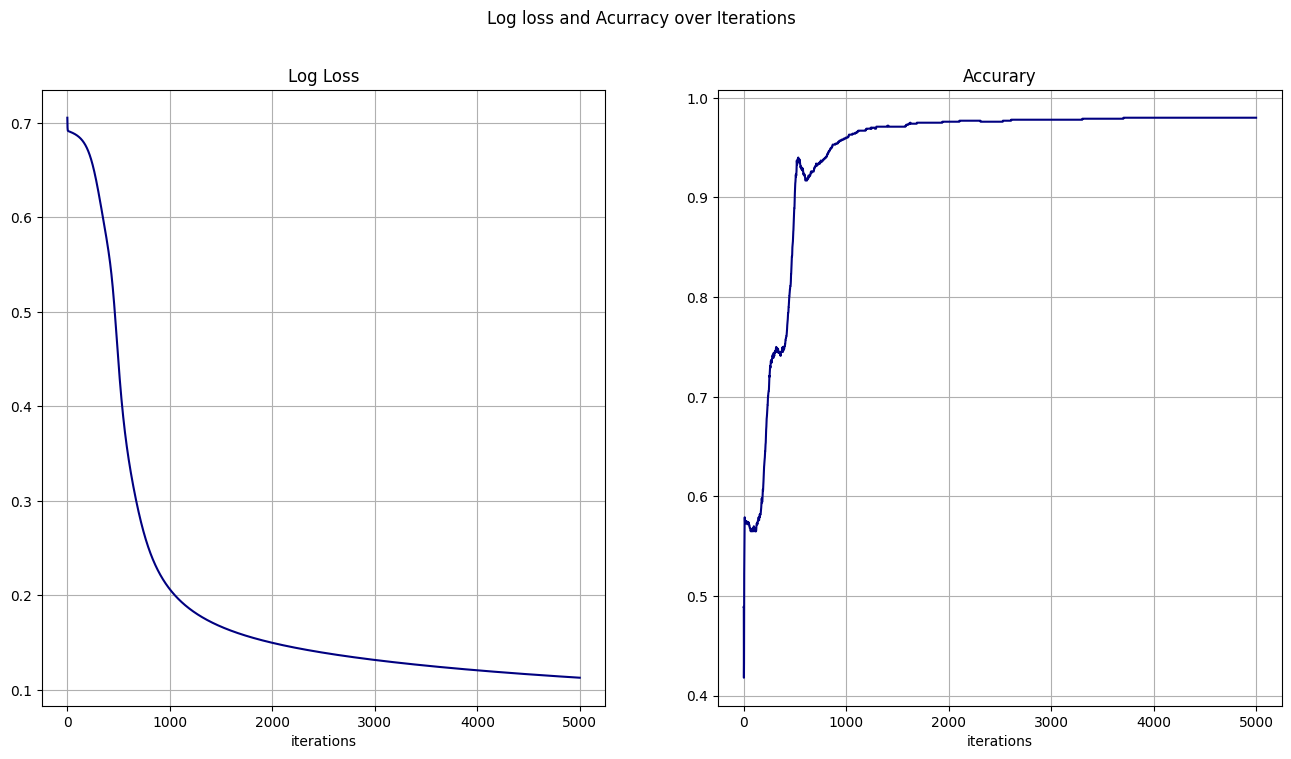

In [122]:
np.random.seed(71)
# Initialize weights with values uniformly drawn from the range (-1, 1)
# Choosing the range (-1, 1) helps to prevent issues like gradient explosion or vanishing gradients
# by keeping the initial weight values relatively small. This initialization ensures that
# the network can start training with stable forward and backward propagations.
W1 = np.random.uniform(-1, 1, size=(3,4))
W2 = np.random.uniform(-1, 1, size = (4))

num_iter = 5000
learning_rate = 0.001
x_mat = x_mat_extended

loss_vals, accuracies = [], []
for i in range(num_iter):
    y_pred, (J_W1_grad, J_W2_grad) = forward_pass(W1, W2)
    W1 = W1 - learning_rate*J_W1_grad  
    W2 = W2 - learning_rate*J_W2_grad
    curr_loss = loss_fn(y,y_pred)
    loss_vals.append(curr_loss)
    acc = np.sum((y_pred>=.5) == y)/sample_size
    accuracies.append(acc)
    if((i%500) == 0):
        print('iteration {}, log loss is {:.4f}, accuracy is {}'.format(
            i, curr_loss, acc
        ))
plot_loss_accuracy(loss_vals, accuracies)

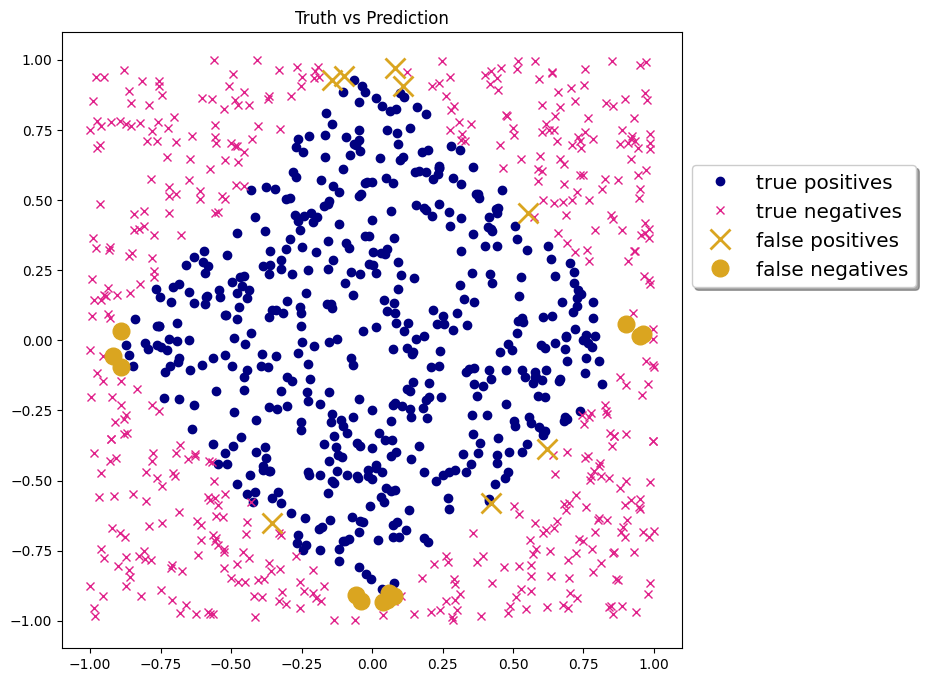

In [123]:
pred1 = (y_pred>=.5)
pred0 = (y_pred<.5)

fig, ax = plt.subplots(figsize=(8, 8))
# true predictions
ax.plot(x_mat[pred1 & (y==1),0],x_mat[pred1 & (y==1),1], 'o', label='true positives', color = '#000080')
ax.plot(x_mat[pred0 & (y==0),0],x_mat[pred0 & (y==0),1], 'x', label='true negatives', color = '#E0218A')
# false predictions
ax.plot(x_mat[pred1 & (y==0),0],x_mat[pred1 & (y==0),1], 'x', label='false positives', markersize=15, markeredgewidth=2, color = 'goldenrod')
ax.plot(x_mat[pred0 & (y==1),0],x_mat[pred0 & (y==1),1], 'o', label='false negatives', markersize=12, color = 'goldenrod')

ax.set(title='Truth vs Prediction')
ax.legend(bbox_to_anchor=(1, 0.8), fancybox=True, shadow=True, fontsize='x-large');

## Conclusion

By experimenting with different patterns and using various activation functions, we observed that the `Sigmoid` function is particularly well-suited for our binary classification tasks. It demonstrates effectiveness in simpler networks, likely because the data distribution and network structure in our case allow for stable gradient updates and appropriate probability outputs. For instance, in patterns like the Diamond and Thin Right Angle patterns, the `Sigmoid` function achieved impressive accuracy rates of around 0.98 to 0.99.

Nevertheless, regardless of the activation function used—whether `Sigmoid`, `Tanh`, or `ReLU`—the model struggled to learn the Ring pattern effectively, achieving only an accuracy of 0.734. The Ring pattern is a highly non-linear distribution that requires the network to capture complex boundaries and relationships. A simple neural network, especially one with only a single hidden layer and a limited number of neurons, often lacks the capacity to accurately fit such a non-linear pattern. To capture this complexity, the network needs to be able to express more non-linear features. Both `Sigmoid` and `Tanh` have relatively small gradients near the boundaries, making it difficult for them to learn complex distributions adequately. Similarly, `ReLU` may also perform poorly with this pattern, as it is better suited for linear separations or simpler non-linear patterns.

To address this challenge, we may need to increase the network’s complexity by adding more hidden layers (allowing for the gradual extraction of more sophisticated features) or consider using more advanced activation functions better equipped to handle intricate patterns.